# Model Description

For $n=1,...,N$,
\begin{align}
Z_n &\sim N(0,\tau^2)\\ 
Y_{n,t} &\sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t})}\right)
\end{align}
for $t=1, ..., T$. This model carries out dimentionality reduction of binary observations $y_{n,k}$'s. Here, the dimention of $\beta$ and $x_{n,t}$ is $D$.<br>
As variational approximation of the posterior $p(z_n|y_n)$, we use $q(z_n)= N(z_n;\mu_n, \sigma_n^2)$

#### We do not consider the use of Renyi divergences

# Import Packages

In [131]:
import tensorflow as tf
import tensorflow_probability as tfp

In [132]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
from matplotlib import pyplot as plt

# Utilities

In [133]:
tf_float_type = tf.float64
np_float_type = np.float64
as_tf_float = lambda x: tf.cast(x, tf_float_type)

In [134]:
def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

In [135]:
sigmoid = lambda x:1/(1+np.exp(-x))

# Generate Toy Dataset

In [136]:
# paramters
ln_tau = np.float64(0.7)
beta0 = np.float64(0.)
beta  = np.random.randn(D) / np.sqrt(D)
param0 = {
    'ln_tau': ln_tau,
    'beta0': float(beta0),
    'beta': beta
}

In [137]:
# data
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, T, beta0, beta, ln_tau):
    z = np.random.randn(N) * np.exp(ln_tau)
    x = np.random.randn(N*T*D).reshape([N,T,D])
    y = bernoulli(p=sigmoid(beta0+x@beta+z.reshape([N,1]))).rvs()
    return x,y,z

In [138]:
N = 1000
D = 3
T = 2

In [139]:
x,y,z = generate_data(N, D, T, beta0, beta, ln_tau)

## Sigmoid Normal Integral Approximation of Evidence

Ref: Barber Bishop(1998), PRML(2006)

In [140]:
def sigmoid_normal_prob(x, beta0, beta, ln_tau):
    n, t, d  = x.shape
    kappa = 1 / (1 + np.pi*tf.exp(ln_tau*2)/8)**(1/2)
    return tf.math.sigmoid( kappa * (beta0 + tf.reshape( x@tf.reshape(beta, [D,1]), [n, T])) )

In [141]:
def sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau):
    pred_prob = sigmoid_normal_prob(x, beta0, beta, ln_tau)
    score = tf.reduce_mean(tf.reduce_sum(
        tf.math.log(pred_prob)*y + tf.math.log(1-pred_prob)*(1-y), 
        axis=1))
    return score

## Laplace Approximation of Posterior

In [142]:
def laplace_approx(x, y, beta0, beta, ln_tau):
    n, T, D  = x.shape
    z = np.zeros([n, 1])
    _sig = lambda z: sigmoid( z + beta0 + x@beta )
    for i in range(10):
        sig = _sig(z)
        hessian = 1/np.exp(ln_tau*2) + np.sum( sig*(1-sig), axis=1, keepdims=True)
        grad    = z/np.exp(ln_tau*2) + np.sum( sig - y,     axis=1, keepdims=True)
        z -= grad / hessian
    mu = z.reshape([n])
    sigma = (1 / hessian).reshape([n])**(1/2)
    return mu, sigma

In [143]:
mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)

In [144]:
z.var(), (z-mu).var()

(4.130907347338663, 1.9946040065682895)

# IWELBO approximation of Evidence

In [145]:
def pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma):
    """
    Compute IWELBOs for i = 1,...,n using n_MC samples Zn. 
    Here, we assume that n<N where N is the size of data.
    
    Arguments:
    x: 3-d array of size [n, T, D]
    y: 2-d array of size [n, T]
    z: 1-d array of size [n_MC, n]
    beta: 1-d array of size [D]
    mu: 1-d array of [n]
    sigma**2: 1-d array of [n]
    
    Returns:
    iwelbo: iwelbo, whose size is [n]
    """

    (n, T, D), (n_MC, n) = x.shape, z.shape
    y = np.float64( y.reshape([1,n,T]) )
    mu = mu.reshape([1,n])
    sigma = sigma.reshape([1,n])
    
    y_logits = tf.convert_to_tensor( beta0\
                                    + tf.reshape( x@tf.reshape(beta, [D,1]), [1, n, T])\
                                    + tf.reshape(z, [n_MC, n, 1]) 
                                   )
    p_y = tfp.distributions.Bernoulli(logits=y_logits)
    p_z = tfp.distributions.Normal(loc=np.zeros([1, n]), scale=tf.exp(ln_tau))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    iwelbo = tf_logmeanexp(log_prob_ratio, axis=0)
    return iwelbo

In [146]:
def IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC):
    n, = mu.shape
    z = norm(loc=mu, scale=sigma).rvs([n_MC, n])
    iwelbo = tf.reduce_mean( pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma) )
    return iwelbo

In [147]:
signorm_likelihood = sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau).numpy()
elbo_likelihood = IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1).numpy()
iwelbo_likelihood = IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64).numpy()

In [148]:
signorm_likelihood, elbo_likelihood, iwelbo_likelihood

(-1.3453549355262067, -1.2799727649308008, -1.2631378995992737)

## Maximum Likelihood by Different Approximation

In [149]:
# Orthogonalize the covariate with z

In [150]:
objectives = {
    "signorm": lambda beta0, beta, ln_tau, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau),
    "elbo": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1),
    "iwelbo": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64)
}
params = {"ground_truth": param0}

N,T,D = 1000, 2, 3

for obj_name, obj_func in objectives.items():
    
    print("training {}...".format(obj_name))
    
    beta0_ = tf.Variable(0, dtype=tf.float64)
    beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
    ln_tau_   = tf.Variable(0, dtype=tf.float64)

    for t in range(501):
        
        rho_t = 0.4/(1+t)**0.6
        x,y,z = generate_data(N, D, T, beta0, beta, ln_tau)

        with tf.GradientTape() as g:
            g.watch([beta0_, beta_, ln_tau_])
            mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), ln_tau_.numpy())
            score = obj_func(beta0_, beta_, ln_tau_, mu, sigma)
        dbeta0_, dbeta_, dln_tau_ = g.gradient(score, [beta0_, beta_, ln_tau_])

        beta0_ = beta0_ + rho_t*dbeta0_
        beta_ = beta_ + rho_t*dbeta_
        ln_tau_ = ln_tau_ + dln_tau_
        if t%50==0:
            print("#iter: {},\tloss: {}".format(t, -score.numpy()))
    
    params[obj_name] = {
        'ln_tau': ln_tau_.numpy(),
        'beta0': beta0_.numpy(),
        'beta': beta_.numpy()
    }
    print()

training signorm...
#iter: 0,	loss: 1.3862943611198932
#iter: 50,	loss: 1.3481196565879132
#iter: 100,	loss: 1.3447647408257335
#iter: 150,	loss: 1.3518931308006963
#iter: 200,	loss: 1.3486989728276797
#iter: 250,	loss: 1.3516026313018978
#iter: 300,	loss: 1.3402616610446163
#iter: 350,	loss: 1.3551532661281345
#iter: 400,	loss: 1.343664061057097
#iter: 450,	loss: 1.3500466739531285
#iter: 500,	loss: 1.3316452321640018

training elbo...
#iter: 0,	loss: 1.3401437165916787
#iter: 50,	loss: 1.2979686663096506
#iter: 100,	loss: 1.2940268439464
#iter: 150,	loss: 1.2825036766565128
#iter: 200,	loss: 1.288800352696763
#iter: 250,	loss: 1.2955594018720673
#iter: 300,	loss: 1.2942937696950572
#iter: 350,	loss: 1.286718374619531
#iter: 400,	loss: 1.2898627608319797
#iter: 450,	loss: 1.2978442480357104
#iter: 500,	loss: 1.309185484765381

training iwelbo...
#iter: 0,	loss: 1.3318654060649402
#iter: 50,	loss: 1.2787510637478003
#iter: 100,	loss: 1.2711447095863055
#iter: 150,	loss: 1.3063030768774

In [151]:
params

{'ground_truth': {'ln_tau': 0.7,
  'beta0': 0.0,
  'beta': array([-0.49585496, -0.44138983, -0.10935024])},
 'signorm': {'ln_tau': -0.4393838742778257,
  'beta0': -0.008806776827671782,
  'beta': array([-0.32041121, -0.29156639, -0.07400701])},
 'elbo': {'ln_tau': -0.19809545847196794,
  'beta0': -0.0014466023401008637,
  'beta': array([-0.36414611, -0.32299035, -0.07947923])},
 'iwelbo': {'ln_tau': 0.6413189267005861,
  'beta0': 0.0006609054398471921,
  'beta': array([-0.43200339, -0.38468579, -0.0966636 ])}}

Bottom Line: IWELBO gives better estiamte than elbo or sigmoid normal integral approximation. 

# MLMC codition check

In [152]:
def pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma):
    
    (n, T, D), (n_MC, n) = x.shape, z.shape
    assert np.log2(n_MC)%1==0
    
    if n_MC == 1:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma)
    else:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[:n_MC//2 ], beta0, beta, ln_tau, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[ n_MC//2:], beta0, beta, ln_tau, mu, sigma)
    return scores

In [153]:
def dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level):
    
    n, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, n])
    
    diwelbo = tf.reduce_mean( pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma) )
    return diwelbo

# MLMC

In [154]:
def IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=8, start_level=0):
    
    N, T, D = x.shape

    levels = np.arange(start_level, max_level+1)
    weights = 2.**(-3/2*levels)
    weights /= sum(weights)
    Ns = np.zeros_like(levels)
    Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
    Ns[0] = N - sum(Ns[1:])
    
    N_offset = 0
    score = 0
    for i, l in enumerate(levels):
        x_tmp = x[N_offset:N_offset+Ns[i]]
        y_tmp = y[N_offset:N_offset+Ns[i]]
        mu_tmp = mu[N_offset:N_offset+Ns[i]]
        sigma_tmp = sigma[N_offset:N_offset+Ns[i]]
        
        score += dIWELBO(x_tmp, y_tmp, beta0, beta, ln_tau, mu_tmp, sigma_tmp, level=l)
        N_offset += Ns[i]
    return score

In [155]:
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=10, start_level=0)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2547080764020955>

## Comparison

In [163]:
def conv_stats_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=1):
    
    n, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, n])
    
    diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
    mean_diwelbo = diwelbos.mean()
    mean_abs_diwelbo = np.mean(np.abs(diwelbos))
    var_diwelbo = diwelbos.var()
    
    iwelbos = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
    var_iwelbo = iwelbos.var()
    
    return {'mean_dIWELBO':mean_diwelbo, 
            'mean_abs_dIWELBO':mean_abs_diwelbo, 
            'var_dIWELBO':var_diwelbo, 
            'var_IWELBO':var_iwelbo}

In [164]:
conv_stats = [conv_stats_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=l) for l in range(10)]
conv_stats = pd.DataFrame(conv_stats)

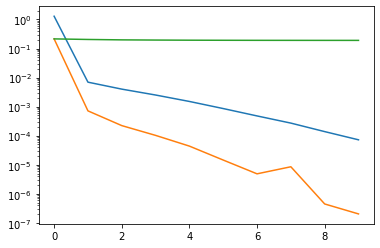

In [165]:
plt.plot(conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO', 'var_IWELBO']])
plt.yscale('log')

In [166]:
conv_stats

,mean_dIWELBO,mean_abs_dIWELBO,var_dIWELBO,var_IWELBO
0,-1.286579,1.288297,2.142389e-01,0.214239
1,0.006955,0.006955,7.157887e-04,0.204806
2,0.004007,0.004007,2.228524e-04,0.198314
3,0.002513,0.002513,1.027039e-04,0.195307
4,0.001509,0.001509,4.390534e-05,0.193255
5,0.000860,0.000860,1.455702e-05,0.192045
6,0.000480,0.000480,4.885327e-06,0.191200
7,0.000272,0.000272,8.554871e-06,0.190853
8,0.000139,0.000139,4.492801e-07,0.190480
9,0.000072,0.000072,2.041902e-07,0.190354


In [167]:
NMC_ests = []
MLMC_ests = []
for i in range(10):
    x,y,z_ = generate_data(N=200000, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    NMC_ests.append( IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=16).numpy() )
    MLMC_ests.append( IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=4, start_level=0).numpy() )

In [168]:
print("std-div of NMC estimator:  ", np.std(NMC_ests))
print("std-div of MLMC estimator: ", np.std(MLMC_ests))

std-div of NMC estimator:   0.0010681426285199416
std-div of MLMC estimator:  0.001467850251896148


In [33]:
%%timeit
IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64)

1.41 s ± 7.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=6, start_level=0)

135 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### For finding nice configuration where MLMC wins NMC 

In [35]:
n,_ = y.shape
n_MC = 2
z = norm(loc=mu, scale=sigma).rvs([n_MC, n])

diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
score1 = np.var(NMC_ests) / diwelbos.mean()**2
score2 = np.var(MLMC_ests) / np.var(NMC_ests)
print(score1, score2)

print(np.std(x@beta, axis=1).mean(), z_.std())

0.011223535213672926 1.7766281227047076
0.5869003546656074 2.013010552806195
